In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import pprint
import fbprophet
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [3]:
url = "https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv"
df = pd.read_csv(url,  sep=',')
df.head(5)

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [4]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [5]:
test_size = int(0.2*(df.shape[0]))
train_df = df.iloc[:-test_size, :]
test_df = df.iloc[-test_size::, :]
pprint.pprint(f"The train dataset has shape {train_df.shape} and test dataset has shape {test_df.shape}")

'The train dataset has shape (2324, 2) and test dataset has shape (581, 2)'


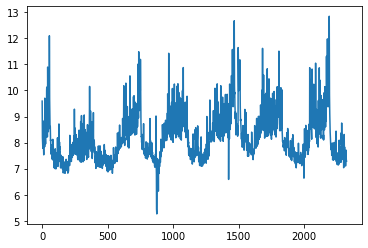

In [6]:
plt.plot(train_df.loc[:,'y'])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


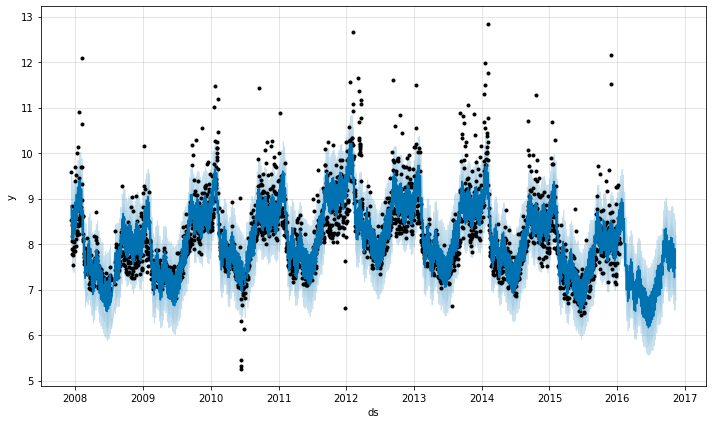

In [7]:
m = fbprophet.Prophet()
m.fit(df.iloc[0:2900])
future = m.make_future_dataframe(periods=300)
fcst = m.predict(future)
fig = m.plot(fcst)

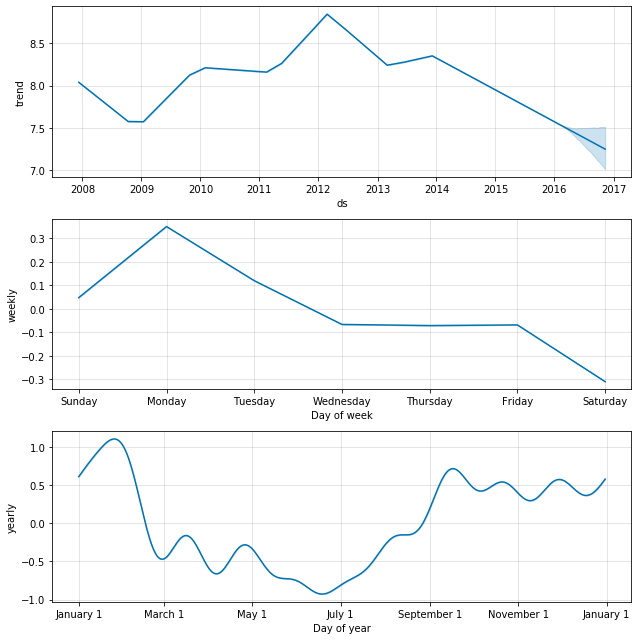

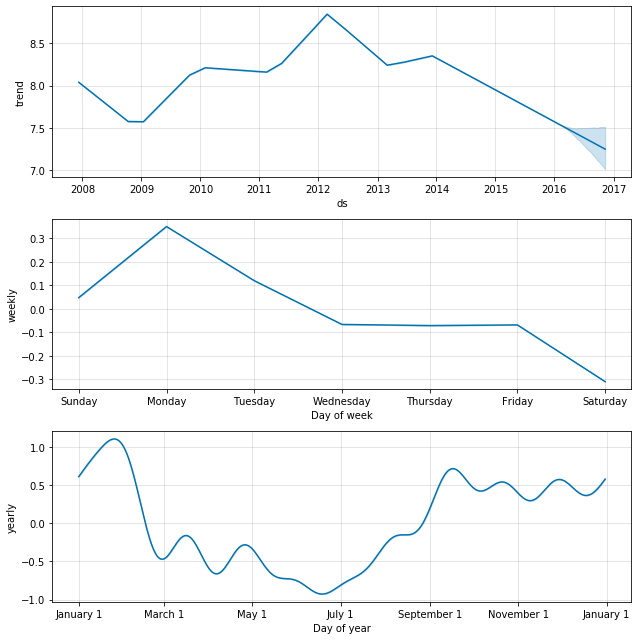

In [8]:
m.plot_components(fcst)

Good explanation of MCMC https://github.com/facebook/prophet/issues/1145

In [175]:
# Set tree depth param in prophet.fit to silence the warnings below - related to NUTS sampler?

# Taken from https://mc-stan.org/misc/warnings.html
# "Warnings about hitting the maximum treedepth are not as serious as warnings about divergent 
# transitions. While divergent transitions are a validity concern, hitting the maximum 
# treedepth is an efficiency concern. Configuring the No-U-Turn-Sampler (the variant of HMC 
# used by Stan) involves putting a cap on the depth of the trees that it evaluates during 
# each iteration (for details on this see the Hamiltonian Monte Carlo Sampling chapter in 
# the Stan manual). This is controlled through a maximum depth parameter max_treedepth. 
# When the maximum allowed tree depth is reached it indicates that NUTS is terminating 
# prematurely to avoid excessively long execution time".

# WARNING:pystan:577 of 600 iterations saturated the maximum tree depth of 10 (96.2 %)
# WARNING:pystan:Run again with max_treedepth larger than 10 to avoid saturation

m = fbprophet.Prophet(mcmc_samples=300)
forecast = m.fit(df.iloc[0:2900], control={'max_treedepth': 12}).predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [182]:
samples = m.predictive_samples(df)['yhat']

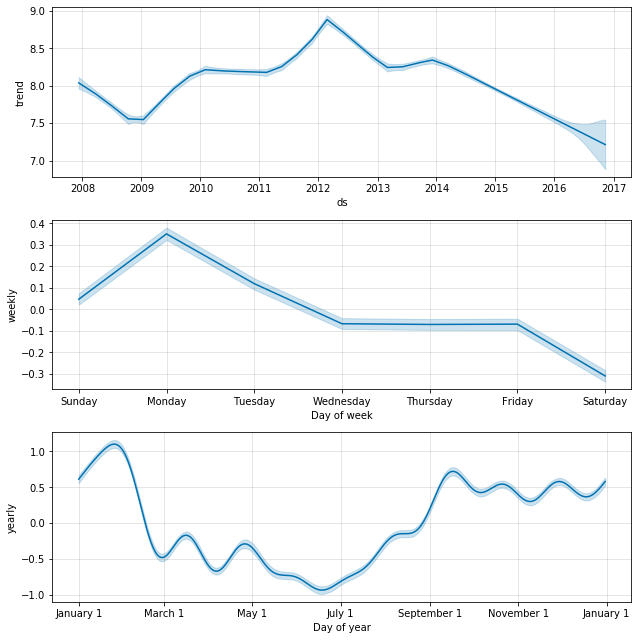

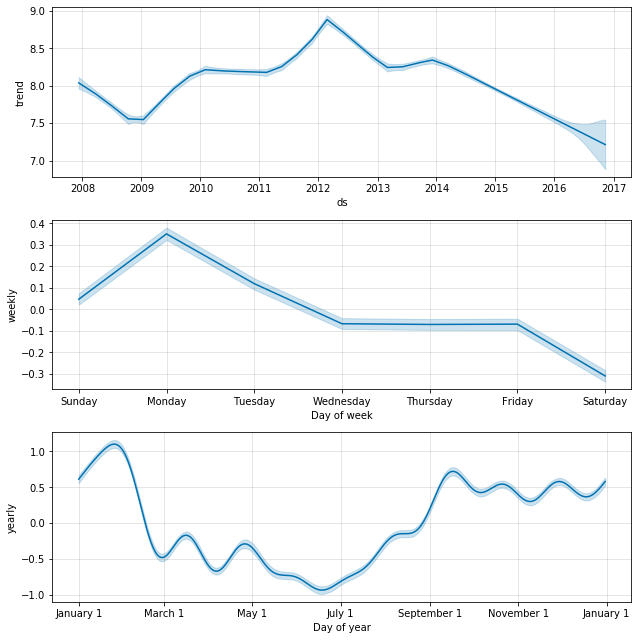

In [183]:
m.plot_components(forecast)

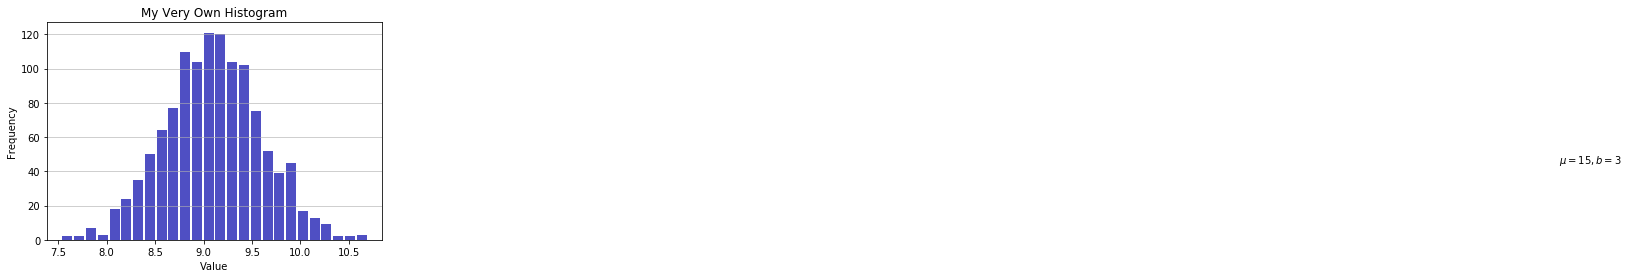

In [201]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=samples[2150], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()